## AdaBoost

중요한 결정을 내리기에 앞서서 한 사람의 조언을 듣기보다는 여러 사람의 조언을 모두 들어보는 게 낫겠죠?

머신러닝에서도 이런 아이디어를 적용시킬 수 있습니다. 이렇게 여러 알고리즘을 한데 섞어서 만들어진 새로운 알고리즘을 메타-알고리즘이라고 합니다.

이번 실습에서는 가장 유명한 메타-알고리즘인 Adaboost에 대해 공부해봅시다.

### Bagging

이론 시간에 배웠듯이 bagging은 하나의 데이터셋에서 샘플들을 복원추출하여 여러 개의 새로운 데이터셋을 만들어낸 뒤 이를 학습에 사용하는 방법입니다.

총 S개의 새로운 데이터셋이 있다고 하면, 그 결과 S개의 classifier가 만들어지게 됩니다.

이 S개의 classifier의 분류 결과 중 가장 많은 vote를 얻은 class를 채택하면 됩니다.

### Boosting

Boosting은 bagging과 비슷한 방법입니다. 차이점은, Bagging의 경우 S개의 classifier가 각각 독립적으로 학습되는 반면 boosting은 순차적으로 학습된다는 점입니다.

즉, boosting에서는 N번째 classifier의 학습은 이미 학습이 완료된 1~N-1번째 classifier의 성능에 따라 달라지는 것입니다.

이 때 1~N-1번째 classifier가 잘못 분류한 샘플에 대해 보다 집중하여 학습함으로써 성능의 향상을 꾀합니다.

Boosting에는 다양한 버전이 있지만, 이번에는 가장 유명한 버전인 Adaboost에 대해서 공부해볼 것입니다.

### AdaBoost : Improving the classifier by focusing on errors

흥미로운 질문이 하나 있습니다.

<b>'약한' 분류기 여러 개를 가지고 '강한' 분류기를 만들 수 있을까요?</b>

여기서 약한 분류기란, 이를테면 binary classification 문제에 대해서 <i>동전을 던져 결정하는 것보다</i> 아주 약간 좋은 성능을 보이는 분류기를 말합니다.

AdaBoost는 Adaptive Boosting의 준말입니다. AdaBoost는 아래와 같이 작동합니다:

먼저 training 데이터셋의 모든 샘플에 모두 동일한 weight가 부여됩니다. 우리는 앞으로 이 weight vector를 $ D $라고 부를 것입니다.

최초로 하나의 약한 분류기가 학습됩니다. 이 약한 분류기에 대한 error를 계산합니다.

두 번째로 약한 분류기를 학습하는데, 이 때 각각의 샘플에 대한 weight가 조정됩니다.

첫 번째 분류기에 의해 제대로 분류된 샘플의 weight은 작게, 그렇지 않은 샘플의 weight은 크게 만드는 것이죠.

분류기 전체의 분류값을 얻기 위해서 AdaBoost 알고리즘은 각 분류기의 error에 기반한 $ \alpha $값들을 분류기마다 할당합니다.

error $ \epsilon $는 아래와 같이 주어집니다.

\begin{equation*}
\epsilon = \frac{\text{number of incorrectly classified examples}}{\text{total number of examples}}
\end{equation*}

$ \alpha $는 아래와 같이 주어집니다.

\begin{equation*}
\alpha = \frac{1}{2}ln(\frac{1-\epsilon}{\epsilon})
\end{equation*}

$ \alpha $값을 계산했다면, 이제 weight vector $ D $를 update해야 합니다.

\begin{equation*}
D^{(i+1)}_i = \frac{D^{(i)}_ie^{-\alpha}}{Sum(D)} \text{if correct}
\end{equation*}
\begin{equation*}
D^{(i+1)}_i = \frac{D^{(i)}_ie^{\alpha}}{Sum(D)} \text{if incorrect}
\end{equation*}

$ D $를 update했다면 AdaBoost의 다음 iteration을 이 과정을 반복함으로써 수행하게 됩니다.

이 반복은 training error가 0이 되거나 weak classifier의 개수가 미리 설정한 값에 도달할 때까지 수행됩니다.

### Creating a weak learner with a decision stump

<i>Decision stump</i>는 이름에서도 알 수 있듯이 아주 간단한 버전의 decision tree라고 생각하면 됩니다.

우리는 weak classifier로 decision stump를 이용할 것입니다.

AdaBoost에 대한 코드를 작성하기 전에, decision stump를 생성하는 함수를 작성합시다.

간단한 데이터셋을 불러옵시다.

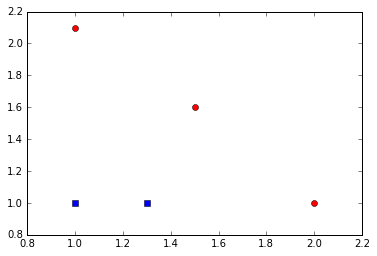

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def loadSimpData():
    datMat = np.matrix([[1., 2.1], [1.5, 1.6], [1.3, 1.], [1., 1.], [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

simpleData, simpleLabels = loadSimpData()

plt.plot(simpleData[[0, 1, 4], 0], simpleData[[0, 1, 4], 1], 'ro')
plt.plot(simpleData[[2, 3], 0], simpleData[[2, 3], 1], 'bs')
plt.axis([0.8, 2.2, 0.8, 2.2])
plt.show()

Stump가 주어지면 이를 바탕으로 데이터셋을 분류하는 함수 <b>stumpClassify()</b>와,

가중치를 반영한 error값을 최소로 만드는 stump를 구하는 함수 <b>buildStump()</b>를 작성합시다.

In [46]:
def stumpClassify(dataMatrix, dimension, threshVal, threshIneq):
    retArray = np.ones((dataMatrix.shape[0], 1))
    if threshIneq == 'lt':  # less than
        retArray[dataMatrix[:, dimension] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimension] > threshVal] = -1.0
    return retArray

def buildStump(dataArr, classLabels, D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    
    m, n = dataMatrix.shape
    
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.zeros((m, 1))
    minError = np.inf
    
    for i in range(n):  # for every feature
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
                # ENDIF
            # ENDFOR - inequal
        # ENDFOR - j
    # ENDFOR - i
    return bestStump, minError, bestClasEst

In [41]:
D = np.mat(np.ones((5, 1)) / 5)
buildStump(simpleData, simpleLabels, D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

이제 AdaBoost를 작성합시다.

In [47]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = dataArr.shape[0]
    D = np.mat(np.ones((m, 1)) / m)
    aggClassEst = np.mat(np.zeros((m, 1)))
    
    # iterate for numIt times
    for i in range(numIt):
        # build best stump
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print("D:", D.T)
        
        # compute alpha
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print("classEst: ", classEst.T)
        
        # update D
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        
        aggClassEst += alpha * classEst
        print("aggClassEst: ", aggClassEst.T)
        
        aggErrors = np.sum(np.sign(aggClassEst) != np.mat(classLabels).T)
        errorRate = aggErrors.sum() / m
        
        print("Total error: ", errorRate)
        # if all correct, break
        if errorRate == 0.0:
            break
    # ENDFOR - i
        
    return weakClassArr

In [48]:
classifierArray = adaBoostTrainDS(simpleData, simpleLabels, 9)

D: [[ 0.2  0.2  0.2  0.2  0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
Total error:  0.2
D: [[ 0.5    0.125  0.125  0.125  0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
Total error:  0.2
D: [[ 0.28571429  0.07142857  0.07142857  0.07142857  0.5       ]]
classEst:  [[ 1.  1.  1.  1.  1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
Total error:  0.0
